In [16]:
from solver import diffuser, params
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pde
from PIL import Image
from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid

img = Image.open('seeds/annulus.png')
# Convert to BW
img = img.convert('L')
# Convert to numpy array
img = np.array(img)
# Put on interval 0-1
img = img / 255
l = img.shape[0]
img = np.pad(img, int(0.5*l), mode='constant')

In [7]:
img.shape

(1109, 1109)

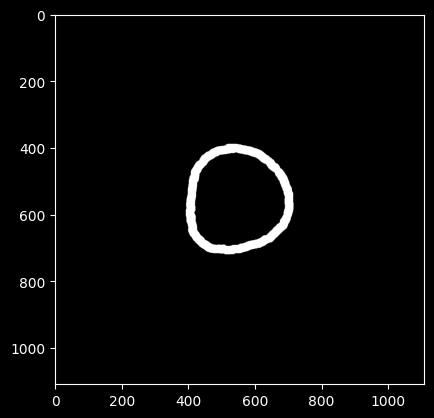

In [8]:
plt.imshow(img, cmap='gray')

In [9]:
class Diffuser(PDEBase):
    def __init__(self, DI, D1, D2, kin, kout, ks, h, Ic, bc="auto_periodic_neumann"):
        self.DI = DI
        self.D1 = D1
        self.D2 = D2
        self.kin = kin
        self.kout = kout
        self.ks = ks
        self.h = h
        self.Ic = Ic
        self.bc = bc

    def evolution_rate(self, state, t=0):
        DI, D1, D2, kin, kout, ks, h, Ic = self.DI, self.D1, self.D2, self.kin, self.kout, self.ks, self.h, self.Ic
        S, S1, S2, I = state
        X = state.copy()
        H = 1/(1 + (I/Ic)**h)
        X[0] = ks*S2
        X[1] = D1 * S1.laplace(bc=self.bc) - H*S1*S2*S2 + kin - kout*S1
        X[2] = D2 * S2.laplace(bc=self.bc) + H*S1*S2*S2 - ks*S2
        X[3] = ks*S2 + DI * I.laplace(bc=self.bc)
        return X

    def _make_pde_rhs_numba(self, state):
        """nunmba-compiled implementation of the PDE"""
        DI, D1, D2, kin, kout, ks, h, Ic = self.DI, self.D1, self.D2, self.kin, self.kout, self.ks, self.h, self.Ic
        laplace = state.grid.make_operator("laplace", bc=self.bc)

        @nb.njit
        def pde_rhs(state_data, t):
            S = state_data[0]
            S1 = state_data[1]
            S2 = state_data[2]
            I = state_data[3]
            H = 1/(1 + (I/Ic)**h)

            rate = np.empty_like(state_data)
            rate[0] = ks * S2
            rate[1] = D1 * laplace(S1) - H*S1*S2*S2 + kin - kout*S1
            rate[2] = D2 * laplace(S2) + H*S1*S2*S2 - ks*S2
            rate[3] = ks*S2 + DI * laplace(I)
            return rate

        return pde_rhs

In [10]:
# initialize state
S2 = img
S1 = np.zeros_like(S2)
S = np.zeros_like(S2)
I = np.zeros_like(S2)

grid = pde.UnitGrid(img.shape, periodic=True)
state = pde.FieldCollection([
    pde.ScalarField(grid, S, label='S'),
    pde.ScalarField(grid, S1, label='S1'),
    pde.ScalarField(grid, S2, label='S2'),
    pde.ScalarField(grid, I, label='I')
])

# simulate the pde
sol = Diffuser(**params).solve(state, t_range=100, dt=0.01, tracker=["progress"])

100%|██████████| 100.0/100.0 [15:34<00:00,  9.34s/it]   


In [17]:
sol.plot()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/icaro-corpa/Documents/repos/reaction_diffusion_simulator/.venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_117138/2421606927.py", line 1, in <module>
    sol.plot()
  File "/home/icaro-corpa/Documents/repos/reaction_diffusion_simulator/.venv/lib/python3.10/site-packages/pde/tools/plotting.py", line 501, in wrapper
  File "/home/icaro-corpa/Documents/repos/reaction_diffusion_simulator/.venv/lib/python3.10/site-packages/pde/fields/collection.py", line 1043, in plot
  File "/home/icaro-corpa/Documents/repos/reaction_diffusion_simulator/.venv/lib/python3.10/site-packages/pde/fields/collection.py", line 1044, in <listcomp>
  File "/home/icaro-corpa/Documents/repos/reaction_diffusion_simulator/.venv/lib/python3.10/site-packages/pde/tools/plotting.py", line 318, in wrapper
  File "/home/icaro-corpa/Documents/repos/reaction_diffusion_simulator/.venv/lib/python3.10/site-packages/pd